In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime


df22 = pd.read_csv('GSE_2022.csv').sort_values(by = 'service_date').reset_index(drop = True)
df23= pd.read_csv('GSE_2023.csv').sort_values(by = 'service_date').reset_index(drop = True)
df24 = pd.read_csv('GSE_2024.csv').sort_values(by = 'service_date').reset_index(drop = True)
df25 = pd.read_csv('GSE_2025.csv').sort_values(by = 'service_date').reset_index(drop = True)
dfw2 = pd.read_csv('Boston, MA, United States... 2023-03-01 to 2025-02-28.csv')
dfw1 = pd.read_csv('Boston, MA, United States... 2022-01-01 to 2023-02-28.csv')



In [ ]:
df = pd.concat([df22, df23, df24, df25]).reset_index(drop = True)
dfw = pd.concat([dfw1, dfw2]).reset_index(drop = True)
dfw = dfw[['datetime', 'temp', 'precip', 'preciptype', 'snow']]
dfw['date'] = pd.to_datetime(dfw['datetime'])
df['date'] = pd.to_datetime(df['service_date'])


df['time_period'] = df['time_period'].str.strip('()')
df['time_period'] = pd.to_timedelta(df['time_period'])

df['time'] = df['date'] + df['time_period']


df = df.merge(dfw, on = 'date')
df = df[['time', 'stop_id', 'route_or_line', 'gated_entries', 'temp', 'precip', 'preciptype', 'snow']]

df = df[(df['route_or_line'] != 'Mattapan Line') & (df['route_or_line'] != 'Silver Line') & (df['route_or_line'] != 'Green Line')]
df = df[df['gated_entries'] < 3500]




In [ ]:
import pandas as pd
import os

# Create the list of months from Jan 2022 to Feb 2025
months = pd.date_range('2022-01-01', '2025-02-01', freq='MS').strftime('%Y-%m').tolist()

# Define a mapping from CSV route_id values to df route_or_line values
route_mapping = {
    'Red': 'Red Line',
    'Blue': 'Blue Line',
    'Orange': 'Orange Line',
    'Green': 'Green Line',
    # Add any other mappings you need
}

# Make sure time column in df is in datetime format
if not pd.api.types.is_datetime64_any_dtype(df['time']):
    df['time'] = pd.to_datetime(df['time'])

# Initialize or reset traincnt column with zeros
df['traincnt'] = 0

# Process one month at a time
for month in months:
    file_path = f'{month}_HREvents.csv'

    # Skip if file doesn't exist
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    try:
        print(f"Processing {month}...")
        # Read the CSV with low_memory=False to handle mixed types
        tempdf = pd.read_csv(file_path, low_memory=False)

        # Parse datetime based on month format
        if month >= '2024-01':
            # Parse ISO format with timezone, then convert to naive datetime by removing timezone
            tempdf['datetime'] = pd.to_datetime(tempdf['event_time']).dt.tz_localize(None)
        else:
            # For earlier months, assume 'event_time' is an epoch timestamp
            tempdf['datetime'] = pd.to_datetime(tempdf['event_time'], unit='s')

        # Create 30-minute intervals
        tempdf['interval'] = tempdf['datetime'].dt.floor('30min')

        # Group by interval and route to count unique vehicles
        interval_counts = tempdf.groupby(['interval', 'route_id'])['vehicle_id'].nunique().reset_index(name='month_count')

        # Rename columns to match your main df
        interval_counts.rename(columns={'interval': 'time', 'route_id': 'route_id_original'}, inplace=True)

        # Map the route_id values to match your main df's route_or_line values
        interval_counts['route_or_line'] = interval_counts['route_id_original'].map(route_mapping)

        # Drop rows where the mapping didn't work
        interval_counts = interval_counts.dropna(subset=['route_or_line'])

        # Free up memory
        del tempdf

        # Now merge
        df = df.merge(interval_counts[['time', 'route_or_line', 'month_count']],
                     on=['time', 'route_or_line'], how='left')

        # Add this month's counts to the running total
        df['month_count'] = df['month_count'].fillna(0)
        df['traincnt'] += df['month_count'].astype(int)
        print(f"Added {df['month_count'].sum()} train counts from {month}")

        # Drop the month_count column
        df.drop(columns=['month_count'], inplace=True)

    except Exception as e:
        print(f"Error processing {month}: {e}")
        import traceback
        traceback.print_exc()

print("\nProcessing complete!")
print(f"Non-zero train count values: {(df['traincnt'] > 0).sum()} out of {len(df)}")



0.08863664179410913

In [ ]:
# Mapping train capacity and line length
train_capacity_dict = {
    'Red Line': 852,
    'Blue Line': 456,
    'Orange Line': 744
}

df['single_traincap'] = df['route_or_line'].map(train_capacity_dict)

line_length_dict = {
    'Red Line': 2520,
    'Blue Line': 1200,
    'Orange Line': 2160
}

df['line_length_sec'] = df['route_or_line'].map(line_length_dict)

# Group by line and time
grouped_by_line = df.groupby(['route_or_line', 'time']).agg({
    'gated_entries': 'sum',
    'temp': 'first',
    'precip': 'first',
    'preciptype': 'first',
    'snow': 'first',
    'traincnt': 'first',
    'single_traincap': 'first',
    'line_length_sec': 'first',
}).reset_index()

# Round gated entries
grouped_by_line['gated_entries'] = grouped_by_line['gated_entries'].round(3)


grouped_by_line['traincnt'] = grouped_by_line['traincnt'].replace(0, np.nan)
grouped_by_line['traincnt'] = grouped_by_line.groupby('route_or_line')['traincnt'].ffill()
grouped_by_line['traincnt'] = grouped_by_line['traincnt'].fillna(0)

# Calculate total line capacity and per-thirty-minute capacity
grouped_by_line['tot_linecap'] = grouped_by_line['traincnt'] * grouped_by_line['single_traincap']
grouped_by_line['per_thirty_cap'] = round((grouped_by_line['tot_linecap'] * (1800 + 60)) / grouped_by_line['line_length_sec'], 3)


# Calculate supply difference
grouped_by_line['supply_gap_simple'] = round(grouped_by_line['gated_entries'] - grouped_by_line['per_thirty_cap'], 3)

grouped_by_line['prev_supply_gap_simple'] = grouped_by_line.groupby('route_or_line')['supply_gap_simple'].shift(1)

grouped_by_line['prev_supply_gap_simple'] = grouped_by_line['prev_supply_gap_simple'].apply(lambda x: max(x, 0))

grouped_by_line['gated_entries_complex'] = grouped_by_line['gated_entries'] + grouped_by_line['prev_supply_gap_simple']

grouped_by_line['supply_gap_complex'] = round(grouped_by_line['gated_entries_complex'] - grouped_by_line['per_thirty_cap'], 3)


# Add date column and group by day
grouped_by_line['date'] = grouped_by_line['time'].dt.date

# Group by line and date
group_by_day_line = grouped_by_line.groupby(['route_or_line', 'date']).agg({
    'gated_entries': 'sum',  # Total gated entries for the day
    'temp': 'first',  # Taking first value (can adjust based on needs)
    'precip': 'first',  # Same as above
    'preciptype': 'first',  # Same as above
    'snow': 'first',  # Same as above
    'traincnt': 'mean',  # Average train count for the day
    'single_traincap': 'first',  # Taking first value
    'line_length_sec': 'first',  # Taking first value
    'tot_linecap': 'mean',  # Mean capacity over the day
    'per_thirty_cap': 'mean',  # Mean per-thirty-minute capacity
    'supply_gap_simple': 'sum',  # Sum of the simple supply gap
    'prev_supply_gap_simple': 'sum',  # Sum of the previous period's supply gap
    'gated_entries_complex': 'sum',  # Sum of complex gated entries
    'supply_gap_complex': 'sum'  # Sum of the complex supply gap
}).reset_index()






orange_line = grouped_by_line[grouped_by_line['route_or_line'] == 'Orange Line'].reset_index(drop = True)
blue_line = grouped_by_line[grouped_by_line['route_or_line'] == 'Blue Line'].reset_index(drop = True)
red_line = grouped_by_line[grouped_by_line['route_or_line'] == 'Red Line'].reset_index(drop = True)



orange_line_day = group_by_day_line[group_by_day_line['route_or_line'] == 'Orange Line'].reset_index(drop = True)
blue_line_day = group_by_day_line[group_by_day_line['route_or_line'] == 'Blue Line'].reset_index(drop = True)
red_line_day = group_by_day_line[group_by_day_line['route_or_line'] == 'Red Line'].reset_index(drop = True)

In [ ]:
df.to_csv('raw_with_weather.csv')

grouped_by_line.to_csv('group_by_line.csv')


orange_line.to_csv('orange_line.csv')
blue_line.to_csv('blue_line.csv')
red_line.to_csv('red_line.csv')


orange_line_day.to_csv('orange_line_day.csv')
blue_line_day.to_csv('blue_line_day.csv')
red_line_day.to_csv('red_line_day.csv')

0.06605412805391744
0.06981552057807515


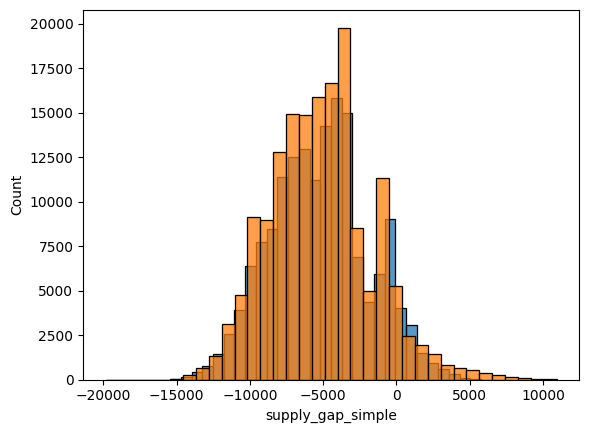

In [ ]:
import seaborn as sns

sns.histplot(data = grouped_by_line, x = 'supply_gap_simple', bins = 35)

short = grouped_by_line[grouped_by_line['supply_gap_simple'] > 0]
surplus = grouped_by_line[grouped_by_line['supply_gap_simple'] < 0]

print(len(short) / len(surplus))




sns.histplot(data = grouped_by_line, x = 'supply_gap_complex', bins = 35)

short = grouped_by_line[grouped_by_line['supply_gap_complex'] > 0]
surplus = grouped_by_line[grouped_by_line['supply_gap_complex'] < 0]

print(len(short) / len(surplus))

